In [1]:
try :
    # % tensorflow_version only exists in Colab .
    % tensorflow_version 2. x
except Exception :
    pass

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import stockstats
import os
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from lib.rens import rens

In [244]:
def create_dataset(dataset, true_price, look_back = 1):
      
    # MinMax
    #min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    #dataset = min_max_scaler.fit_transform(dataset)
    
    # Standarised
    sc = preprocessing.StandardScaler()
    dataset = sc.fit_transform(dataset)

    
    #print(dataset)
    lookback = look_back
    datax = []
    datay = []
    
    # Time1
    # [x1, x2, x3]
    # time2
    # [x1, x2, x3]
    # Target y kan være som det er
    # (sampels, lookbacks, features)
    
    # Append først den ene så den andre
    datax1 = []
    datax2 = []
    #for i,features in enumerate(dataset):
    #    if i > lookback:
    #        for j in range(lookback, 0, -1):
                
                
            #datax1.append([dataset[i-j][0] for j in range(lookback, 0, -1)]) #x1
            #datax2.append([dataset[i-j][1] for j in range(lookback, 0, -1)]) #x2
    #        datay.append(true_price[i])  
    
    for i,v in enumerate(dataset):
        if i > lookback:
            datax.append([dataset[i-j] for j in range(lookback, 0, -1)])
            datay.append(true_price[i])    

    #datax.append(datax1)
    #datax.append(datax2)
    
    datax = np.array(datax)
    datay = np.array(datay)
    
    # Standardize y data
    mean = datay.mean(axis=0)
    datay -= mean
    std = datay.std(axis=0)
    datay /= std

    print(datax.shape)
    
    
    
    # Normalize
    #datax = preprocessing.normalize(datax)
    #datay = preprocessing.normalize(datay)
    
    # reshape input to be [samples, time steps, features]
    #datax = np.reshape(datax, (datax.shape[0], lookback, 1))
    
    return datax, datay

In [3]:
def make_ready(filer):
    for i, fil in enumerate(filer):
        print(f"{i+1} av {len(filer)} renset" ,end='\r')
        data = cleanup.clean_data(pd.read_excel(fil))
        stock = stockstats.StockDataFrame.retype(data)
        indikatorer = ['rsi_20', 'trix', 'open_8_sma', 'open_16_sma', 'macds', 'open_30_sma', 'open_5_sma']
        for ind in indikatorer:
            stock.get(ind)
        stock['sma8-16'] = [stock.open_8_sma[i] - stock.open_16_sma[i] for i, value in enumerate(stock.open_8_sma)]
        stock['sma30_derivert'] = [stock.open_30_sma[i] / stock.open_30_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_30_sma)]
        stock['sma5_derivert'] = [stock.open_5_sma[i] / stock.open_5_sma[i-1] if i>1 else 1 
                                   for i, value in enumerate(stock.open_5_sma)]
        stock['derivert'] = [stock.open[i] / stock.open[i-1] if i>1 else 1
                             for i, value in enumerate(stock.open)]

        #evaluate_trades(stock)
        break # må tas bort ettervært
    
    return stock

    
def add_data(word):
    ordet = 'data/' + word
    return ordet

In [4]:
cleanup = rens()

In [258]:
filer = list(map(add_data, os.listdir('data/')))[8:9] # 60 første er lagd til å bygge modell
data = make_ready(filer)
data

C:\Users\Stian\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
NOTE: Behavior of MACDH calculation has changed as of July 2017 - it is now 1/2 of previous calculated values


,tid,open,close,high,low,volume,amount,close_-1_s,close_-1_d,rs_20,...,open_16_sma,macd,macds,macdh,open_30_sma,open_5_sma,sma8-16,sma30_derivert,sma5_derivert,derivert
0,9:0,508.5,508.5,508.5,508.5,1879,1879,NaN,NaN,NaN,...,508.5000,0.000000,0.000000,0.000000,508.500000,508.500,0.0000,1.000000,1.000000,1.000000
1,9:1,505.0,505.0,505.0,505.0,173,173,508.5,-3.5,0.000000,...,506.7500,-0.078526,-0.043625,-0.034900,506.750000,506.750,0.0000,1.000000,1.000000,1.000000
2,9:2,506.0,506.0,506.0,506.0,605,605,505.0,1.0,0.300752,...,506.5000,-0.069047,-0.054044,-0.015003,506.500000,506.500,0.0000,0.999507,0.999507,1.001980
3,9:3,510.0,510.0,510.0,510.0,821,821,506.0,4.0,1.567076,...,507.3750,0.081374,-0.008171,0.089545,507.375000,507.375,0.0000,1.001728,1.001728,1.007905
4,9:4,512.5,512.5,512.5,512.5,1611,1611,510.0,2.5,2.400183,...,508.4000,0.260879,0.071865,0.189013,508.400000,508.400,0.0000,1.002020,1.002020,1.004902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,16:16,494.4,494.4,494.4,494.4,2008,2008,494.0,0.4,0.442490,...,495.5000,-1.027096,-0.938562,-0.088534,496.553333,494.280,-0.7750,0.999705,0.999676,1.000810
292,16:17,494.6,494.6,494.6,494.6,1321,1321,494.4,0.2,0.489764,...,495.3500,-0.985352,-0.947920,-0.037432,496.413333,494.280,-0.7250,0.999718,1.000000,1.000405
293,16:18,494.0,494.0,494.0,494.0,3118,3118,494.6,-0.6,0.426146,...,495.1375,-0.989281,-0.956192,-0.033088,496.253333,494.200,-0.7375,0.999678,0.999838,0.998787
294,16:19,494.6,494.6,494.6,494.6,722,722,494.0,0.6,0.562877,...,495.0125,-0.933222,-0.951598,0.018377,496.133333,494.320,-0.6875,0.999758,1.000243,1.001215


In [259]:
datax, datay = create_dataset(data[['macd', 'rsi_20', 'sma8-16', 'trix']], data.sma30_derivert, look_back=5)

(290, 5, 4)


In [260]:
datax

array([[[ 0.45484854, -5.40033659,  0.36454537, -7.25075313],
        [ 0.48008926, -2.59501067,  0.36454537, -4.37525664],
        [ 0.8806608 ,  2.00629467,  0.36454537, -1.19191262],
        [ 1.35867982,  3.16435077,  0.36454537,  1.29289328],
        [ 1.00668454,  0.06388838,  0.36454537,  1.69061737]],

       [[ 0.48008926, -2.59501067,  0.36454537, -4.37525664],
        [ 0.8806608 ,  2.00629467,  0.36454537, -1.19191262],
        [ 1.35867982,  3.16435077,  0.36454537,  1.29289328],
        [ 1.00668454,  0.06388838,  0.36454537,  1.69061737],
        [ 0.71472423, -0.11906366,  0.36454537,  1.46453104]],

       [[ 0.8806608 ,  2.00629467,  0.36454537, -1.19191262],
        [ 1.35867982,  3.16435077,  0.36454537,  1.29289328],
        [ 1.00668454,  0.06388838,  0.36454537,  1.69061737],
        [ 0.71472423, -0.11906366,  0.36454537,  1.46453104],
        [ 0.51813969, -0.11906366,  0.36454537,  1.10916731]],

       ...,

       [[-1.87992208, -2.03533932, -1.00367279, -1.

In [248]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(input_dim=datax.shape[2], units=256, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=264, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, None, 256)         267264    
_________________________________________________________________
dropout_46 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 264)               550176    
_________________________________________________________________
dropout_47 (Dropout)         (None, 264)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 265       
Total params: 817,705
Trainable params: 817,705
Non-trainable params: 0
_________________________________________________________________


In [249]:
history = model.fit(datax, datay, epochs=300, batch_size=64, validation_split=0.2,
         callbacks= [keras.callbacks.EarlyStopping(
                                    monitor='val_loss', patience=10, restore_best_weights=True)])

Train on 343 samples, validate on 86 samples
Epoch 1/300
343/343 [==============================] - 10s 29ms/sample - loss: 0.6580 - val_loss: 0.3566
Epoch 2/300
343/343 [==============================] - 1s 2ms/sample - loss: 0.3858 - val_loss: 0.2420
Epoch 3/300
343/343 [==============================] - 1s 2ms/sample - loss: 0.3501 - val_loss: 0.2677
Epoch 4/300
343/343 [==============================] - 1s 2ms/sample - loss: 0.3488 - val_loss: 0.2244
Epoch 5/300
343/343 [==============================] - 1s 2ms/sample - loss: 0.3465 - val_loss: 0.2170
Epoch 6/300
343/343 [==============================] - 1s 2ms/sample - loss: 0.3094 - val_loss: 0.2502
Epoch 7/300
343/343 [==============================] - 1s 2ms/sample - loss: 0.2961 - val_loss: 0.2110
Epoch 8/300
343/343 [==============================] - 1s 2ms/sample - loss: 0.2874 - val_loss: 0.2066
Epoch 9/300
343/343 [==============================] - 1s 2ms/sample - loss: 0.2773 - val_loss: 0.1871
Epoch 10/300
343/343 [====

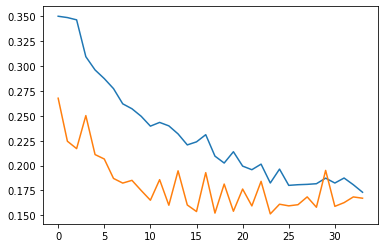

In [250]:
plt.plot(history.history['loss'][2:])
plt.plot(history.history['val_loss'][2:])

In [256]:
predict = model.predict(datax)

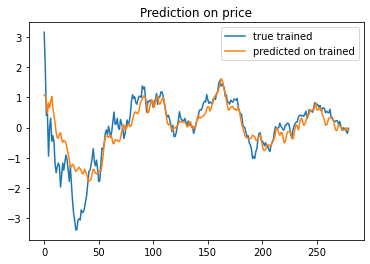

In [257]:
plt.plot(datay, label='true trained')
plt.plot(predict, label='Predicted')
plt.legend()
plt.title('Prediction on price')
#plt.savefig('images/RNN_on_derivert30sma')
plt.show()


In [373]:
predict

array([[165.44948],
       [165.44948],
       [165.44948],
       [165.44945],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44948],
       [165.44948],
       [165.44946],
       [165.44946],
       [165.44948],
       [165.44948],
       [165.44948],
       [165.44948],
       [165.44948],
       [165.44946],
       [165.44948],
       [165.44948],
       [165.44946],
       [165.44946],
       [165.44946],
       [165.44946],


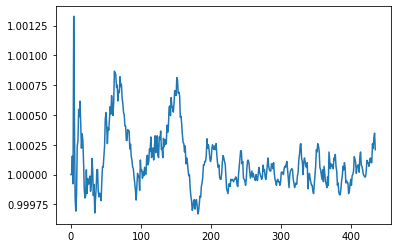

In [68]:
plt.plot(data.sma30_derivert)
#plt.plot(data.sma5_derivert)